# Run and process the prior monte carlo and pick a "truth" realization

A great advantage of exploring a synthetic model is that we can enforce a "truth" and then evaluate how our various attempts to estimate it perform. One way to do this is to run a monte carlo ensemble of multiple parameter realizations and then choose one of them to represent the "truth". That will be accomplished in this notebook.

In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu

### set the `t_d` or "template directory" variable to point at the template folder and read in the PEST control file

In [2]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### Decide what pars are uncertain in the truth

We need to decide what our truth looks like - should the pilot points or the grid-scale pars be the source of spatial variability? or both?

In [3]:
par = pst.parameter_data
# grid pars
#should_fix = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
# pp pars
#should_fix = par.loc[par.pargp.apply(lambda x: "pp" in x),"parnme"]
#pst.npar - should_fix.shape[0]

In [4]:
pe = pyemu.ParameterEnsemble.from_binary(pst=pst,filename=os.path.join(t_d,"prior.jcb"))
#pe.loc[:,should_fix] = 1.0
pe.to_csv(os.path.join(t_d,"sweep_in.csv"))

new binary format detected...


### run the prior ensemble in parallel locally
This takes advantage of the program `pestpp-swp` which runs a parameter sweep through a set of parameters. By default, `pestpp-swp` reads in the ensemble from a file called `sweep_in.csv` which in this case we made just above.

In [5]:
m_d = "master_prior_sweep"
pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things



In [8]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
print('number of realization in the ensemble before dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble before dropping: 200


drop any failed runs

In [9]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
print('number of realization in the ensemble **after** dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble **after** dropping: 200


### confirm which quantities were identified as forecasts

In [10]:
fnames = pst.pestpp_options["forecasts"].split(',')
fnames

['fa_hw_19791230',
 'fa_hw_19801229',
 'fa_tw_19791230',
 'fa_tw_19801229',
 'hds_00_013_002_000',
 'hds_00_013_002_001',
 'part_time',
 'part_status']

### now we can plot the distributions of each forecast

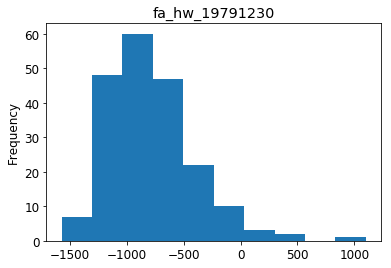

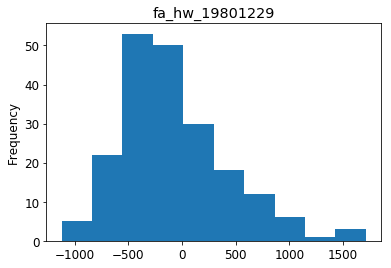

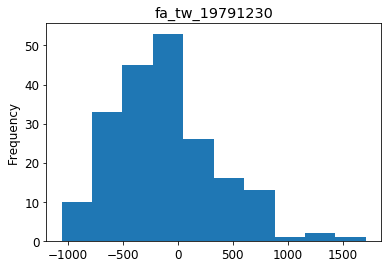

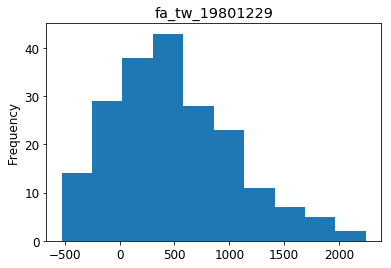

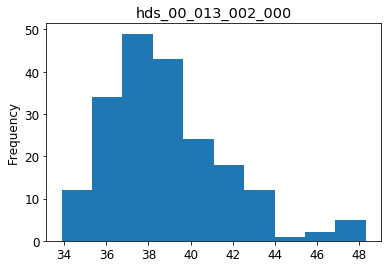

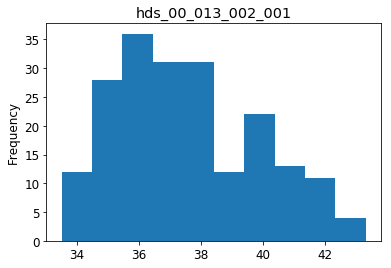

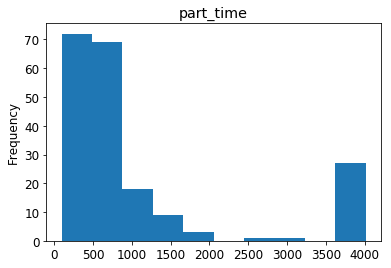

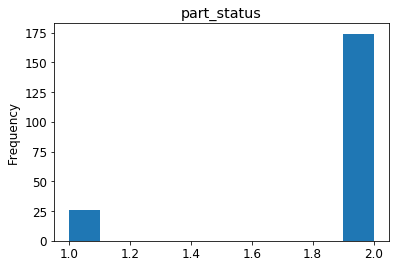

In [13]:
for forecast in fnames:
    plt.figure()
    ax = obs_df.loc[:,forecast].plot(kind="hist")
    ax.set_title(forecast)
plt.show()

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

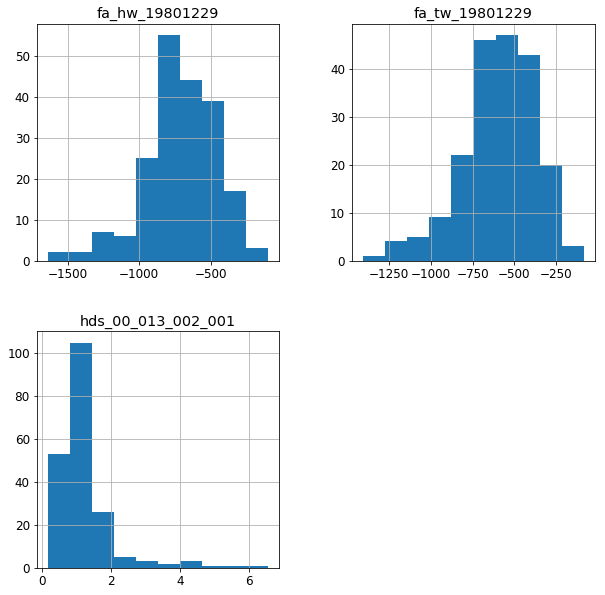

In [14]:
sfnames = [f for f in fnames if "1980" in f or "_001" in f]
hfnames = [f for f in fnames if "1979" in f or "_000" in f]
diff = obs_df.loc[:,hfnames].values - obs_df.loc[:,sfnames].values
diff = pd.DataFrame(diff,columns=sfnames)
diff.hist(figsize=(10,10))
plt.show()

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

### setting the "truth"

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  I'm going to pick a realization that yields an "average" variability of the observed gw levels:

In [15]:
# choose the realization with a low historic gw to sw headwater flux
hist_swgw = obs_df.loc[:,"fa_hw_19791230"].sort_values()
idx = hist_swgw.index[10]
idx

155

In [16]:
obs_df.loc[idx,pst.nnz_obs_names]

fo_39_19791230        10129.000000
hds_00_002_009_000       36.817608
hds_00_002_015_000       34.968674
hds_00_003_008_000       37.100540
hds_00_009_001_000       39.050640
hds_00_013_010_000       35.460297
hds_00_015_016_000       34.788952
hds_00_021_010_000       35.395096
hds_00_022_015_000       34.682060
hds_00_024_004_000       36.450806
hds_00_026_006_000       35.468582
hds_00_029_015_000       34.285713
hds_00_033_007_000       33.863701
hds_00_034_010_000       33.474442
Name: 155, dtype: float64

Lets see how our selected truth does with the sw/gw forecasts:

In [17]:
obs_df.loc[idx,fnames]

fa_hw_19791230       -1241.486400
fa_hw_19801229        -145.724980
fa_tw_19791230        -271.958817
fa_tw_19801229         406.881510
hds_00_013_002_000      39.441250
hds_00_013_002_001      37.485989
part_time             4015.000000
part_status              1.000000
Name: 155, dtype: float64

Assign some initial weights. Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [19]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
obs.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
obs.loc[obs.obgnme=="calhead","weight"] = 10.0
obs.loc[obs.obgnme=="calflux","weight"] = 0.075


here we just get a sample from a random normal distribution with mean=0 and std=1.
The argument indicates how many samples we want - and we choose `pst.nnz_obs` which is the 
the number of nonzero-weighted observations in the PST file

In [20]:
np.random.seed(seed=0)
snd = np.random.randn(pst.nnz_obs)
noise = snd * 1./obs.loc[pst.nnz_obs_names,"weight"]
#pst.observation_data.loc[noise.index,"obsval"] += noise

Then we write this out to a new file and run `pestpp-ies` to see how the objective function looks

In [18]:
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

Now we can read in the results and make some figures showing residuals and the balance of the objective function

9704.38223943
Here are the non-zero weighted observation names


<Figure size 432x288 with 0 Axes>

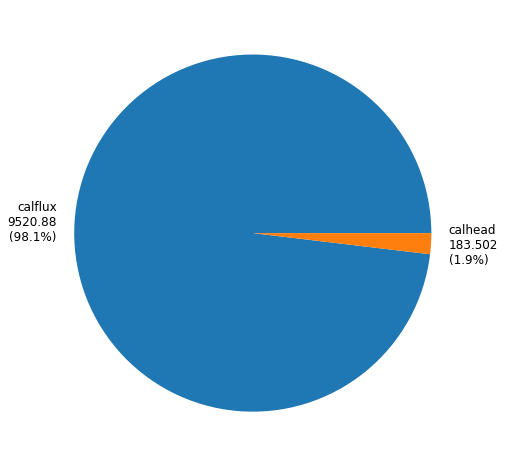

<Figure size 576x756 with 0 Axes>

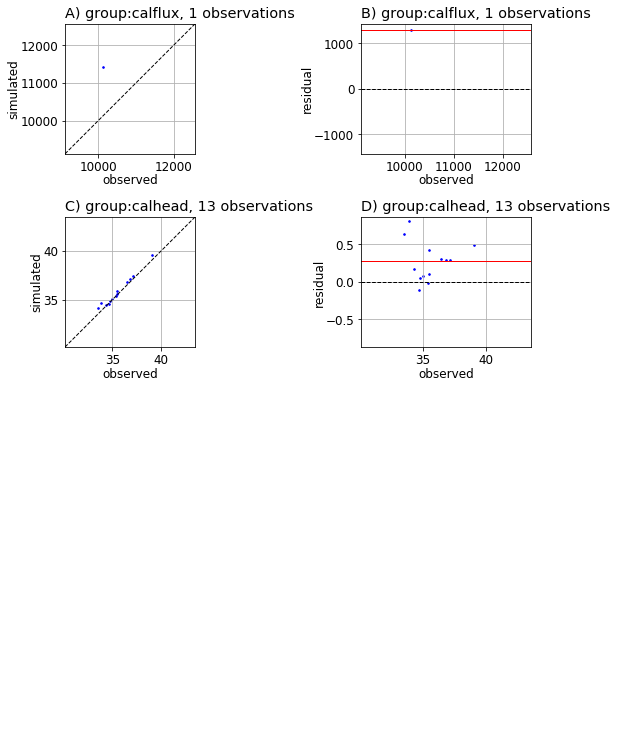

,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,10129.000000,11430.000000,-1301.000000,0.075
hds_00_002_009_000,hds_00_002_009_000,calhead,36.817608,37.107502,-0.289894,10.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.968674,35.045200,-0.076527,10.000
hds_00_003_008_000,hds_00_003_008_000,calhead,37.100540,37.397293,-0.296753,10.000
hds_00_009_001_000,hds_00_009_001_000,calhead,39.050640,39.546421,-0.495781,10.000
hds_00_013_010_000,hds_00_013_010_000,calhead,35.460297,35.571777,-0.111481,10.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.788952,34.835720,-0.046768,10.000
hds_00_021_010_000,hds_00_021_010_000,calhead,35.395096,35.386246,0.008850,10.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.682060,34.577477,0.104584,10.000


In [29]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
plt.figure()
pst.plot(kind='phi_pie')
print('Here are the non-zero weighted observation names')

figs = pst.plot(kind="1to1")
plt.show()
pst.res.loc[pst.nnz_obs_names,:]


Publication ready figs - oh snap!

Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a `phi` equivalent to the noise vector:

In [ ]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))

we will run this with `noptmax=0` to preform a single run. Pro-tip: you can use any of the `pestpp-###` binaries/executables to run `noptmax=0`

In [31]:
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

7.28020339809e-17


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,10129.000000,10129.000000,0.000000e+00,0.075
hds_00_002_009_000,hds_00_002_009_000,calhead,36.817608,36.817608,3.613252e-10,10.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.968674,34.968674,-5.469047e-11,10.000
hds_00_003_008_000,hds_00_003_008_000,calhead,37.100540,37.100540,-1.328146e-10,10.000
hds_00_009_001_000,hds_00_009_001_000,calhead,39.050640,39.050640,-2.011689e-10,10.000
hds_00_013_010_000,hds_00_013_010_000,calhead,35.460297,35.460297,1.406235e-10,10.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.788952,34.788952,2.207017e-10,10.000
hds_00_021_010_000,hds_00_021_010_000,calhead,35.395096,35.395096,-1.953140e-10,10.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.682060,34.682060,3.007798e-10,10.000


The residual should be exactly the noise values from above.Lets load the model (that was just run using the true pars) and check some things

In [32]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

0.0267308 1.29296


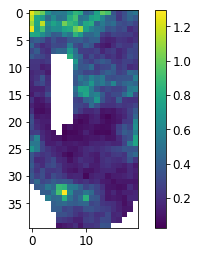

In [36]:
a = m.upw.vka[1].array
#a = m.rch.rech[0].array
a = np.ma.masked_where(m.bas6.ibound[0].array==0,a)
print(a.min(),a.max())
c = plt.imshow(a)
plt.colorbar()
plt.show()

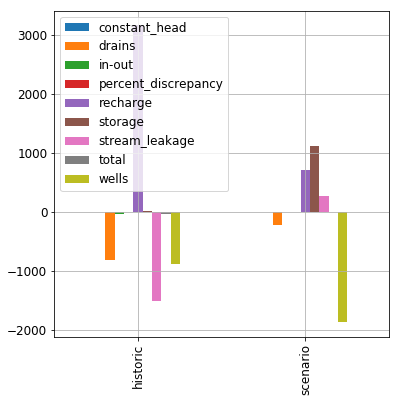

In [43]:
lst = flopy.utils.MfListBudget(os.path.join(m_d,"freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6), grid=True)
a = ax.set_xticklabels(["historic","scenario"],rotation=90)
plt.show(ax)

### see how our existing observation ensemble compares to the truth

sw-gw outputs:

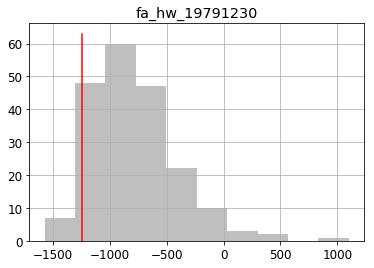

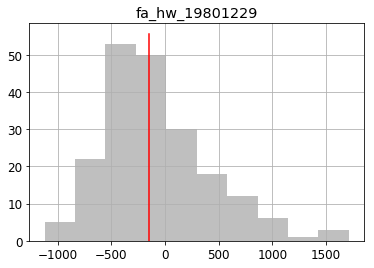

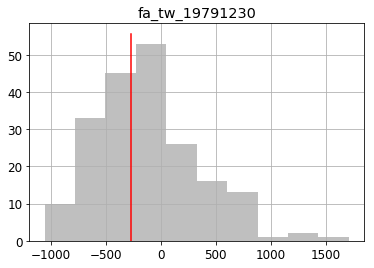

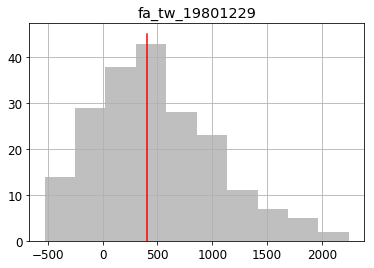

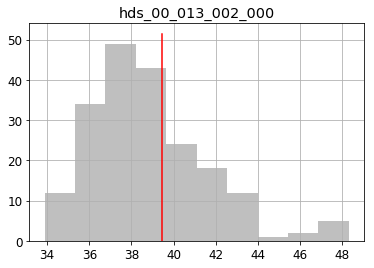

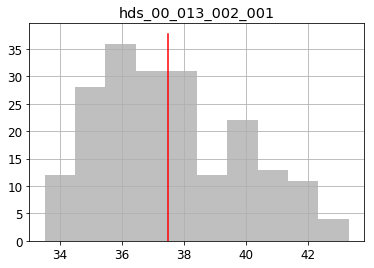

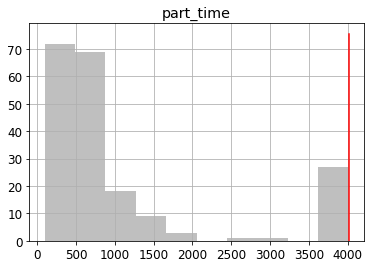

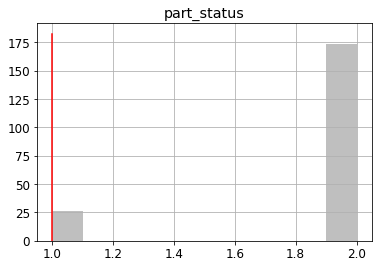

In [44]:
obs = pst.observation_data
plt.figure()
for forecast in fnames:
    ax = plt.subplot(111)
    obs_df.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

observations:

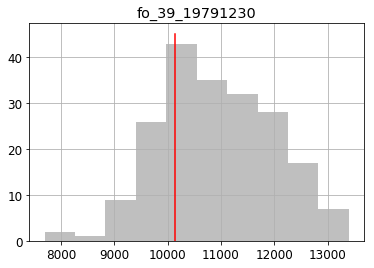

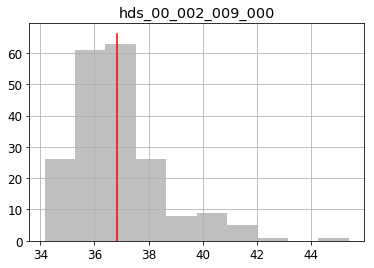

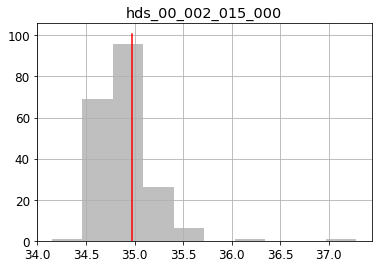

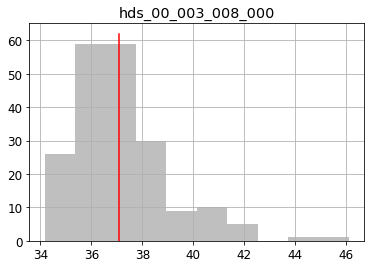

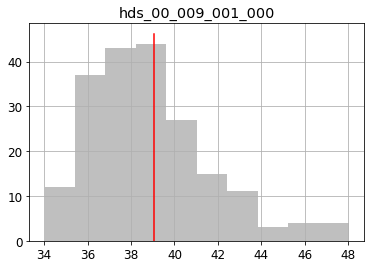

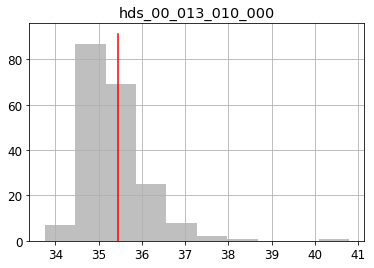

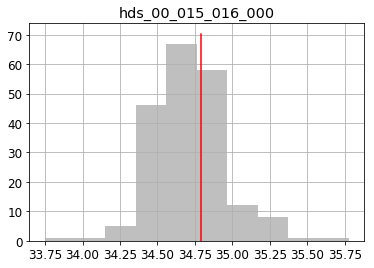

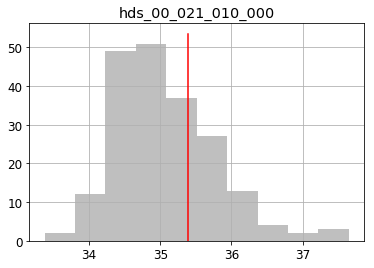

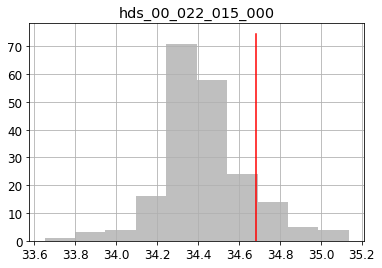

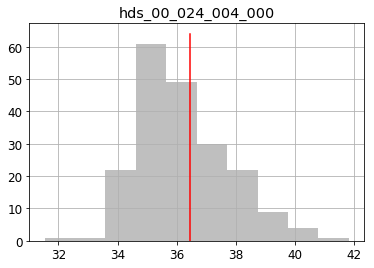

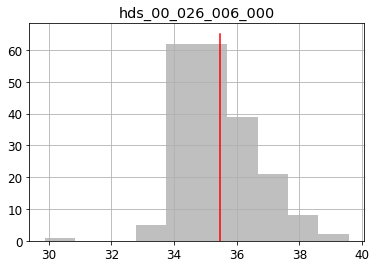

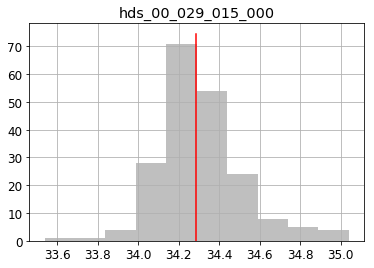

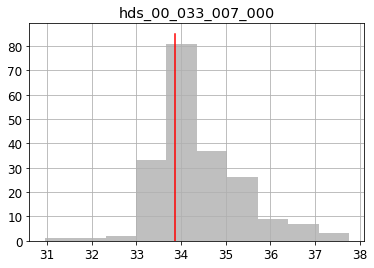

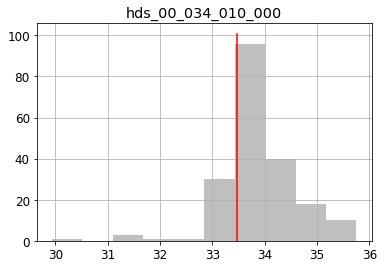

In [45]:
for oname in pst.nnz_obs_names:
    ax = plt.subplot(111)
    obs_df.loc[:,oname].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[oname,"obsval"],obs.loc[oname,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(oname)
    plt.show()